In [26]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [27]:
from matplotlib import pyplot as plt
from matplotlib import rcParams
import numpy as np
from pathlib import Path
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
import warnings

from sklearn.model_selection import train_test_split, KFold, cross_val_score, StratifiedKFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from hyperopt import STATUS_OK, Trials, hp, space_eval, tpe, fmin
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import plot_model, to_categorical
from sklearn.ensemble import RandomForestClassifier
import re

In [28]:
rcParams['figure.figsize'] = (16, 8)
plt.style.use('fivethirtyeight')
pd.set_option('max_columns', 100)
pd.set_option("display.precision", 4)
warnings.simplefilter('ignore')

In [29]:
ls "./open"

 C 드라이브의 볼륨: SSD
 볼륨 일련 번호: BCA4-98AF

 C:\Users\inhoinno\DACON\2020_DACON-Kaggle\소설저자AI\open 디렉터리

2020-12-04  오후 12:56    <DIR>          .
2020-12-04  오후 12:56    <DIR>          ..
2020-10-21  오전 06:15           322,396 sample_submission.csv
2020-12-04  오후 01:26    <DIR>          sub
2020-10-21  오전 06:15         9,842,421 test_x.csv
2020-10-21  오전 06:15        13,389,485 train.csv
2020-11-20  오후 05:29        32,383,317 train_processed_500.csv
               4개 파일          55,937,619 바이트
               3개 디렉터리  29,048,553,472 바이트 남음


In [30]:
data_dir = Path('./open')
trn_file = data_dir / 'train_processed_500.csv'
tst_file = data_dir / 'test_x.csv'
submission = pd.read_csv("./open/sample_submission.csv")

val_dir = Path('./ensemble/build/val')
tst_dir = Path('./ensemble/build/tst')
sub_dir = Path('./ensemble/build/sub')

algo_name_lgbm = 'lgbm'
algo_name_rf = 'rf'
feature_name = 'tfidf'
model_name_lgbm = f'{algo_name_lgbm}_{feature_name}'
model_name_rf = f'{algo_name_rf}_{feature_name}'

p_val_file_lgbm = val_dir / f'{model_name_lgbm}.val.csv'
p_val_file_rf = val_dir / f'{model_name_rf}.val.csv'

p_tst_file_lgbm = tst_dir / f'{model_name_lgbm}.tst.csv'
p_tst_file_rf = tst_dir / f'{model_name_rf}.tst.csv'

seed = 42


In [31]:
train = pd.read_csv(trn_file)
test = pd.read_csv(tst_file)

print(train.info())
print(test.info())
print(train.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183468 entries, 0 to 183467
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   index   183468 non-null  int64 
 1   text    183468 non-null  object
 2   author  183468 non-null  int64 
 3   length  183468 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 5.6+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19617 entries, 0 to 19616
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   index   19617 non-null  int64 
 1   text    19617 non-null  object
dtypes: int64(1), object(1)
memory usage: 306.6+ KB
None
(183468, 4)


<h2> 문자열 전처리

In [32]:
def alpha_num(text):
    return re.sub(r'[^A-Za-z0-9 ]', '', text)


def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stopwords:
            final_text.append(i.strip())
    return " ".join(final_text)


stopwords = [ "a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", 
             "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", 
             "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", 
             "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", 
             "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", 
             "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", 
             "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that", 
             "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", 
             "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll", 
             "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom", 
             "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves" ]

In [33]:
train['text'] = train['text'].str.lower().apply(alpha_num).apply(remove_stopwords)
test['text'] = test['text'].str.lower().apply(alpha_num).apply(remove_stopwords)

In [34]:
idx_under_20 = train[train['length'] < 20].index
train = train.drop(idx_under_20)
train = train.reset_index()
train.describe()

,level_0,index,author,length
count,181013.0000,181013.0000,181013.0000,181013.0000
mean,91514.5870,91514.5870,2.0491,164.5379
std,53025.4182,53025.4182,1.2863,178.6952
min,0.0000,0.0000,0.0000,20.0000
25%,45490.0000,45490.0000,1.0000,65.0000
50%,91441.0000,91441.0000,2.0000,113.0000
75%,137458.0000,137458.0000,3.0000,189.0000
max,183467.0000,183467.0000,4.0000,2454.0000


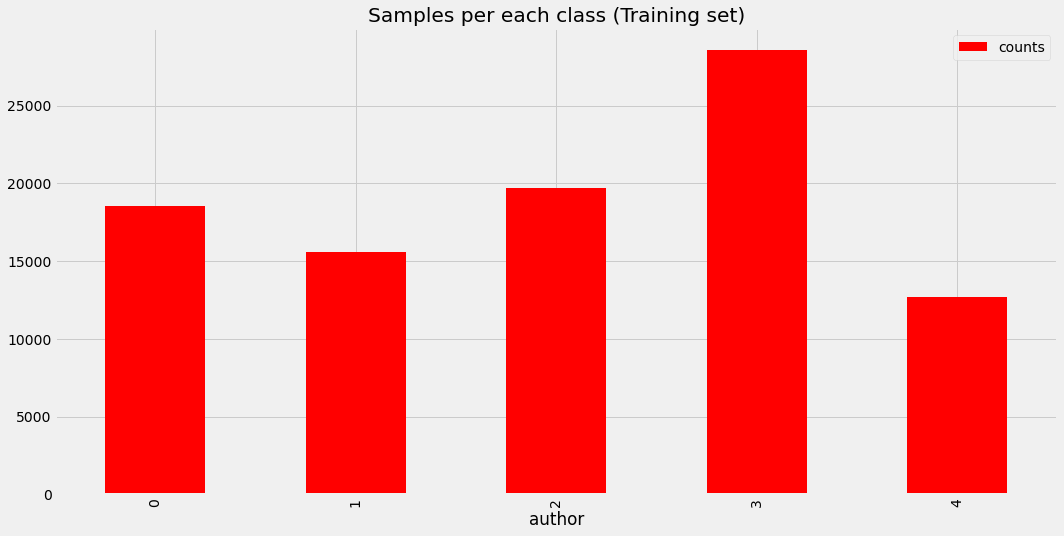

In [35]:
df = train.drop_duplicates(['text'])
df.groupby(df.author).size().reset_index(name="counts").plot.bar(x='author',title="Samples per each class (Training set)",color='red')

In [36]:
df = df.drop(columns = ['level_0'])
df = df.reset_index()
df['index'] = df['index'].reset_index()

In [37]:
train = df
train= train.drop(columns=['level_0'])
train

,index,text,author,length
0,0,almost choking much much wanted say strange ex...,3,235
1,1,sister asked suppose,2,34
2,2,engaged one day walked perusing janes last let...,1,312
3,3,captain porch keeping carefully way treacherou...,4,305
4,4,mercy gentlemen odin flung hands dont write an...,3,215
...,...,...,...,...
95080,95080,diningroom soon joined odin odin busily engage...,1,150
95081,95081,one came books toilette,1,56
95082,95082,faces however tolerably calm no change visible...,1,252
95083,95083,still ticking hall,2,29


In [38]:
trn = train['text'].values
tst = test['text'].values
y = train['author'].values
print(trn.shape, tst.shape, y.shape)

(95085,) (19617,) (95085,)


<h2>Lemmatization -> Tfidf

In [39]:
import nltk
#nltk.download('wordnet')
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer 
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer


In [40]:

lemmatizer = nltk.stem.WordNetLemmatizer()
def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in word_tokenize(text)]

train['text'] = train['text'].apply(lemmatize_text)
test['text'] = test['text'].apply(lemmatize_text)

In [41]:
def to__string(text):
    return ' '.join(text)

train['text'] = train['text'].apply(to__string)
test['text'] = test['text'].apply(to__string)

In [42]:
tfidf_model = TfidfVectorizer(max_features = 1000)
df = pd.DataFrame(tfidf_model.fit_transform(train['text']).todense())


In [43]:
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,...,950,951,952,953,954,955,956,957,958,959,960,961,962,963,964,965,966,967,968,969,970,971,972,973,974,975,976,977,978,979,980,981,982,983,984,985,986,987,988,989,990,991,992,993,994,995,996,997,998,999
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2896,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,...,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,...,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,...,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.239,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,...,0.1804,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,...,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.3469,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95080,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5101,0.0,0.0,0.0,0.0,0.0,...,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
95081,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,...,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
95082,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.3679,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,...,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [44]:
tst = pd.DataFrame(tfidf_model.fit_transform(test['text']).todense())
y = train['author']

In [45]:
train

,index,text,author,length
0,0,almost choking much much wanted say strange ex...,3,235
1,1,sister asked suppose,2,34
2,2,engaged one day walked perusing janes last let...,1,312
3,3,captain porch keeping carefully way treacherou...,4,305
4,4,mercy gentleman odin flung hand dont write any...,3,215
...,...,...,...,...
95080,95080,diningroom soon joined odin odin busily engage...,1,150
95081,95081,one came book toilette,1,56
95082,95082,face however tolerably calm no change visible ...,1,252
95083,95083,still ticking hall,2,29


In [46]:
test

,index,text
0,0,not think one charming young lady ever met mig...
1,1,no replied sudden consciousness not find can n...
2,2,lady stated intention screaming course screame...
3,3,suddenly silence heard sound sent heart mouth ...
4,4,conviction remained unchanged far knowand beli...
...,...,...
19612,19612,end another day two odin growing visibly stron...
19613,19613,afternoon sat together mostly silence watching...
19614,19614,odin carried thanks odin proceeded happiness l...
19615,19615,soon upon odin leaving room mama said odin ala...


In [47]:
'''num_tokens = len(voc) + 2
embedding_dim = 100
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print(f"Converted {hits} words ({misses} misses)")
'''

'num_tokens = len(voc) + 2\nembedding_dim = 100\nhits = 0\nmisses = 0\n\n# Prepare embedding matrix\nembedding_matrix = np.zeros((num_tokens, embedding_dim))\nfor word, i in word_index.items():\n    embedding_vector = embeddings_index.get(word)\n    if embedding_vector is not None:\n        # Words not found in embedding index will be all-zeros.\n        # This includes the representation for "padding" and "OOV"\n        embedding_matrix[i] = embedding_vector\n        hits += 1\n    else:\n        misses += 1\nprint(f"Converted {hits} words ({misses} misses)")\n'

In [48]:
#토큰화
'''
train_sequences = tokenizer.texts_to_sequences(X_train)
train_padded = pad_sequences(train_sequences, padding=padding_type, maxlen=max_length)

test_sequences = tokenizer.texts_to_sequences(X_test)
test_padded = pad_sequences(test_sequences, padding=padding_type, maxlen=max_length)
'''

'\ntrain_sequences = tokenizer.texts_to_sequences(X_train)\ntrain_padded = pad_sequences(train_sequences, padding=padding_type, maxlen=max_length)\n\ntest_sequences = tokenizer.texts_to_sequences(X_test)\ntest_padded = pad_sequences(test_sequences, padding=padding_type, maxlen=max_length)\n'

In [49]:
'''
trn = train['text'].values
tst = test['text'].values
y = train['author'].values
print(trn.shape, tst.shape, y.shape)
'''

"\ntrn = train['text'].values\ntst = test['text'].values\ny = train['author'].values\nprint(trn.shape, tst.shape, y.shape)\n"

In [50]:
trn = df
print(trn.shape, y.shape, tst.shape)

(95085, 1000) (95085,) (19617, 1000)


In [51]:
from sklearn import tree
dtc = tree.DecisionTreeClassifier()
dtc = dtc.fit(trn, y)
trn['predicted_labels'] = dtc.predict(trn)

<h1> LGBM </h1>

<h4>LBGM model 1) Hyper Optuna</h4>

In [52]:
import lightgbm as lgb

In [53]:
#Normal
X = trn
#y = train['author']
seed = 777

In [54]:
X_trn, X_val, y_trn, y_val = train_test_split(X, y, test_size=.2, random_state=seed)

In [55]:
params = {
    "objective": "multiclass",
    "n_estimators": 1000,
    "subsample_freq": 1,
    "random_state": seed,
    "n_jobs": -1,
}

space = {
    "learning_rate": hp.loguniform("learning_rate", np.log(0.01), np.log(0.1)),
    "num_leaves": hp.choice("num_leaves", np.arange(20, 100,10)),
    "colsample_bytree": hp.quniform("colsample_bytree", .7, .9, 0.05),
    "subsample": hp.quniform("subsample", .8, 1.0, 0.05),
    "min_child_samples": hp.choice('min_child_samples', np.arange(50,80,5))
}

In [56]:
def objective(hyperparams):
    model = lgb.LGBMClassifier(**params, **hyperparams)
    model.fit(X=X_trn, y=y_trn,
              eval_set=[(X_val, y_val)],
              eval_metric="multi_logloss",
              early_stopping_rounds=30,
              verbose=False)
    score = model.best_score_["valid_0"]["multi_logloss"]

    return {'loss': score, 'status': STATUS_OK, 'model': model}

trials = Trials()
best = fmin(fn=objective, space=space, trials=trials,
            algo=tpe.suggest, max_evals=10, verbose=1)

hyperparams = space_eval(space, best)
n_best = trials.best_trial['result']['model'].best_iteration_
params.update(hyperparams)
print(params)

100%|██████████| 10/10 [13:27<00:00, 80.80s/trial, best loss: 0.11197286294042795]
{'objective': 'multiclass', 'n_estimators': 1000, 'subsample_freq': 1, 'random_state': 777, 'n_jobs': -1, 'colsample_bytree': 0.8, 'learning_rate': 0.01423586689291947, 'min_child_samples': 70, 'num_leaves': 80, 'subsample': 0.8500000000000001}


LGBM CV

In [57]:
#n_stacking =30 #5 for lgbm * 2 ,  5 for xgboost *2 , 5 for rf * 2 
n_fold = 5
n_class = 5
#cv = KFold(n_splits = n_fold, shuffle = True, random_state = 1)
cv = StratifiedKFold(n_splits = n_fold, shuffle = False, random_state = 1)

In [58]:
print(y.shape, trn.shape, tst.shape)

(95085,) (95085, 1001) (19617, 1000)


In [59]:
for i, (i_trn, i_val) in enumerate(cv.split(trn, y), 1):
    print((i_trn,i_val))

(array([15192, 15196, 15199, ..., 95082, 95083, 95084]), array([    0,     1,     2, ..., 24142, 24143, 24151]))
(array([    0,     1,     2, ..., 95082, 95083, 95084]), array([15192, 15196, 15199, ..., 46880, 46894, 46902]))
(array([    0,     1,     2, ..., 95082, 95083, 95084]), array([30651, 30659, 30661, ..., 65272, 65273, 65274]))
(array([    0,     1,     2, ..., 95082, 95083, 95084]), array([45863, 45874, 45878, ..., 79275, 79276, 79277]))
(array([    0,     1,     2, ..., 79275, 79276, 79277]), array([66482, 66483, 66484, ..., 95082, 95083, 95084]))


In [60]:
a= np.array([1,2,100])
trn = trn.drop(columns=['predicted_labels'])

In [61]:
tst

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,...,950,951,952,953,954,955,956,957,958,959,960,961,962,963,964,965,966,967,968,969,970,971,972,973,974,975,976,977,978,979,980,981,982,983,984,985,986,987,988,989,990,991,992,993,994,995,996,997,998,999
0,0.000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0000,0.0,0.0,0.0000,0.0,0.0000,0.0,0.0000,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.2876,0.0000,0.0,0.0000,0.0,0.2338,0.0,0.0000,0.0,0.0000,0.0000,0.0000,0.0000,0.0,0.0,0.0,0.0000,0.0000,0.0,0.0000,0.0000,0.2638,0.0,0.0,0.0,0.0,0.0000,0.0000,0.2012,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.1648,0.0,0.0,0.0
1,0.000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0000,0.0,0.0,0.0000,0.0,0.0000,0.0,0.0000,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0000,0.0000,0.0,0.2278,0.0,0.0000,0.0,0.0000,0.0,0.0000,0.0000,0.0000,0.0000,0.0,0.0,0.0,0.0000,0.0000,0.0,0.0000,0.0000,0.0000,0.0,0.0,0.0,0.0,0.0000,0.0000,0.0000,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0000,0.0,0.0,0.0
2,0.000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0000,0.0,0.0,0.0000,0.0,0.0000,0.0,0.0000,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0000,0.0000,0.0,0.0000,0.0,0.0000,0.0,0.0000,0.0,0.0000,0.0000,0.0000,0.0000,0.0,0.0,0.0,0.4202,0.0000,0.0,0.0000,0.0000,0.0000,0.0,0.0,0.0,0.0,0.0000,0.0000,0.0000,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0000,0.0,0.0,0.0
3,0.000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0000,0.0,0.0,0.1125,0.0,0.0000,0.0,0.0000,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0845,0.0000,0.0,0.0000,0.0,0.0000,0.0,0.0000,0.0,0.0000,0.0000,0.0000,0.0000,0.0,0.0,0.0,0.0000,0.0000,0.0,0.1176,0.0000,0.0000,0.0,0.0,0.0,0.0,0.0000,0.0000,0.1182,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0936,0.0,0.0000,0.0,0.0,0.0
4,0.000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0000,0.0,0.0,0.0000,0.0,0.2503,0.0,0.0000,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0000,0.0000,0.0,0.0000,0.0,0.0000,0.0,0.0000,0.0,0.0000,0.0000,0.0000,0.0000,0.0,0.0,0.0,0.0000,0.0000,0.0,0.0000,0.0000,0.0000,0.0,0.0,0.0,0.0,0.0000,0.0000,0.0000,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19612,0.000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0000,0.0,0.0,0.0000,0.0,0.0000,0.0,0.0000,0.0,0.0,0.0,0.0,0.1089,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0000,0.1403,0.0,0.0897,0.0,0.0000,0.0,0.0000,0.0,0.0000,0.1409,0.0000,0.0000,0.0,0.0,0.0,0.0000,0.1271,0.0,0.0000,0.0000,0.0000,0.0,0.0,0.0,0.0,0.0000,0.0000,0.0000,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0000,0.0,0.0,0.0
19613,0.000,0.1279,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2502,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0000,0.0,0.0,0.0942,0.0,0.0000,0.0,0.0824,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0000,0.0000,0.0,0.0000,0.0,0.0000,0.0,0.0972,0.0,0.08

In [62]:
p_val = np.zeros((trn.shape[0], n_class))
p_tst0 = np.zeros((tst.shape[0], n_class))

for i, (i_trn, i_val) in enumerate(cv.split(trn, y), 1):
    print(f'training model for CV #{i}')
    lgb_clf0 = lgb.LGBMClassifier(**params)
    lgb_clf0.fit(X=trn.iloc[i_trn],y=y.iloc[i_trn],
            eval_set=[(trn.iloc[i_val],y.iloc[i_val])],
                 eval_metric="multi_logloss",
            early_stopping_rounds=30)
    p_val[i_val, :] = lgb_clf0.predict_proba(trn.iloc[i_val])
    p_tst0 += lgb_clf0.predict_proba(tst) / n_fold #n_fold

training model for CV #1
[1]	valid_0's multi_logloss: 1.56283
Training until validation scores don't improve for 30 rounds
[2]	valid_0's multi_logloss: 1.55509
[3]	valid_0's multi_logloss: 1.54759
[4]	valid_0's multi_logloss: 1.53977
[5]	valid_0's multi_logloss: 1.53171
[6]	valid_0's multi_logloss: 1.52454
[7]	valid_0's multi_logloss: 1.51702
[8]	valid_0's multi_logloss: 1.50969
[9]	valid_0's multi_logloss: 1.50286
[10]	valid_0's multi_logloss: 1.49602
[11]	valid_0's multi_logloss: 1.48997
[12]	valid_0's multi_logloss: 1.48374
[13]	valid_0's multi_logloss: 1.47769
[14]	valid_0's multi_logloss: 1.47144
[15]	valid_0's multi_logloss: 1.46544
[16]	valid_0's multi_logloss: 1.45955
[17]	valid_0's multi_logloss: 1.45405
[18]	valid_0's multi_logloss: 1.44877
[19]	valid_0's multi_logloss: 1.44347
[20]	valid_0's multi_logloss: 1.43848
[21]	valid_0's multi_logloss: 1.43375
[22]	valid_0's multi_logloss: 1.42903
[23]	valid_0's multi_logloss: 1.42446
[24]	valid_0's multi_logloss: 1.4198
[25]	valid_0

[213]	valid_0's multi_logloss: 1.09025
[214]	valid_0's multi_logloss: 1.08957
[215]	valid_0's multi_logloss: 1.08885
[216]	valid_0's multi_logloss: 1.08811
[217]	valid_0's multi_logloss: 1.08734
[218]	valid_0's multi_logloss: 1.0866
[219]	valid_0's multi_logloss: 1.08586
[220]	valid_0's multi_logloss: 1.08513
[221]	valid_0's multi_logloss: 1.08444
[222]	valid_0's multi_logloss: 1.08373
[223]	valid_0's multi_logloss: 1.08299
[224]	valid_0's multi_logloss: 1.08228
[225]	valid_0's multi_logloss: 1.08156
[226]	valid_0's multi_logloss: 1.08089
[227]	valid_0's multi_logloss: 1.0802
[228]	valid_0's multi_logloss: 1.0795
[229]	valid_0's multi_logloss: 1.07881
[230]	valid_0's multi_logloss: 1.07815
[231]	valid_0's multi_logloss: 1.07747
[232]	valid_0's multi_logloss: 1.07688
[233]	valid_0's multi_logloss: 1.07627
[234]	valid_0's multi_logloss: 1.0756
[235]	valid_0's multi_logloss: 1.07496
[236]	valid_0's multi_logloss: 1.07428
[237]	valid_0's multi_logloss: 1.07364
[238]	valid_0's multi_logloss

[424]	valid_0's multi_logloss: 1.00315
[425]	valid_0's multi_logloss: 1.00294
[426]	valid_0's multi_logloss: 1.0027
[427]	valid_0's multi_logloss: 1.00248
[428]	valid_0's multi_logloss: 1.00228
[429]	valid_0's multi_logloss: 1.00208
[430]	valid_0's multi_logloss: 1.00191
[431]	valid_0's multi_logloss: 1.00173
[432]	valid_0's multi_logloss: 1.00151
[433]	valid_0's multi_logloss: 1.00132
[434]	valid_0's multi_logloss: 1.0011
[435]	valid_0's multi_logloss: 1.00086
[436]	valid_0's multi_logloss: 1.00061
[437]	valid_0's multi_logloss: 1.00042
[438]	valid_0's multi_logloss: 1.00021
[439]	valid_0's multi_logloss: 1.00001
[440]	valid_0's multi_logloss: 0.999814
[441]	valid_0's multi_logloss: 0.999613
[442]	valid_0's multi_logloss: 0.999454
[443]	valid_0's multi_logloss: 0.999299
[444]	valid_0's multi_logloss: 0.999107
[445]	valid_0's multi_logloss: 0.9989
[446]	valid_0's multi_logloss: 0.998719
[447]	valid_0's multi_logloss: 0.998533
[448]	valid_0's multi_logloss: 0.998347
[449]	valid_0's mult

[630]	valid_0's multi_logloss: 0.976274
[631]	valid_0's multi_logloss: 0.976191
[632]	valid_0's multi_logloss: 0.976121
[633]	valid_0's multi_logloss: 0.976062
[634]	valid_0's multi_logloss: 0.976002
[635]	valid_0's multi_logloss: 0.975923
[636]	valid_0's multi_logloss: 0.975838
[637]	valid_0's multi_logloss: 0.975765
[638]	valid_0's multi_logloss: 0.975692
[639]	valid_0's multi_logloss: 0.975617
[640]	valid_0's multi_logloss: 0.975559
[641]	valid_0's multi_logloss: 0.975513
[642]	valid_0's multi_logloss: 0.975428
[643]	valid_0's multi_logloss: 0.97533
[644]	valid_0's multi_logloss: 0.975243
[645]	valid_0's multi_logloss: 0.975172
[646]	valid_0's multi_logloss: 0.975117
[647]	valid_0's multi_logloss: 0.975044
[648]	valid_0's multi_logloss: 0.97498
[649]	valid_0's multi_logloss: 0.974928
[650]	valid_0's multi_logloss: 0.974871
[651]	valid_0's multi_logloss: 0.974782
[652]	valid_0's multi_logloss: 0.974701
[653]	valid_0's multi_logloss: 0.974641
[654]	valid_0's multi_logloss: 0.97457
[65

[836]	valid_0's multi_logloss: 0.967557
[837]	valid_0's multi_logloss: 0.967542
[838]	valid_0's multi_logloss: 0.967538
[839]	valid_0's multi_logloss: 0.967519
[840]	valid_0's multi_logloss: 0.967516
[841]	valid_0's multi_logloss: 0.967476
[842]	valid_0's multi_logloss: 0.967444
[843]	valid_0's multi_logloss: 0.96741
[844]	valid_0's multi_logloss: 0.967375
[845]	valid_0's multi_logloss: 0.967373
[846]	valid_0's multi_logloss: 0.967376
[847]	valid_0's multi_logloss: 0.967385
[848]	valid_0's multi_logloss: 0.967375
[849]	valid_0's multi_logloss: 0.967353
[850]	valid_0's multi_logloss: 0.967326
[851]	valid_0's multi_logloss: 0.967287
[852]	valid_0's multi_logloss: 0.967269
[853]	valid_0's multi_logloss: 0.967257
[854]	valid_0's multi_logloss: 0.967235
[855]	valid_0's multi_logloss: 0.967229
[856]	valid_0's multi_logloss: 0.96719
[857]	valid_0's multi_logloss: 0.967152
[858]	valid_0's multi_logloss: 0.967135
[859]	valid_0's multi_logloss: 0.967119
[860]	valid_0's multi_logloss: 0.967109
[8

[40]	valid_0's multi_logloss: 1.35587
[41]	valid_0's multi_logloss: 1.35252
[42]	valid_0's multi_logloss: 1.34894
[43]	valid_0's multi_logloss: 1.3455
[44]	valid_0's multi_logloss: 1.34222
[45]	valid_0's multi_logloss: 1.33894
[46]	valid_0's multi_logloss: 1.33576
[47]	valid_0's multi_logloss: 1.3326
[48]	valid_0's multi_logloss: 1.32946
[49]	valid_0's multi_logloss: 1.32643
[50]	valid_0's multi_logloss: 1.32342
[51]	valid_0's multi_logloss: 1.32055
[52]	valid_0's multi_logloss: 1.31753
[53]	valid_0's multi_logloss: 1.31464
[54]	valid_0's multi_logloss: 1.31185
[55]	valid_0's multi_logloss: 1.30907
[56]	valid_0's multi_logloss: 1.30627
[57]	valid_0's multi_logloss: 1.30374
[58]	valid_0's multi_logloss: 1.30104
[59]	valid_0's multi_logloss: 1.29848
[60]	valid_0's multi_logloss: 1.29589
[61]	valid_0's multi_logloss: 1.29345
[62]	valid_0's multi_logloss: 1.29093
[63]	valid_0's multi_logloss: 1.28854
[64]	valid_0's multi_logloss: 1.2861
[65]	valid_0's multi_logloss: 1.28388
[66]	valid_0's 

[253]	valid_0's multi_logloss: 1.0665
[254]	valid_0's multi_logloss: 1.06594
[255]	valid_0's multi_logloss: 1.06533
[256]	valid_0's multi_logloss: 1.06477
[257]	valid_0's multi_logloss: 1.06422
[258]	valid_0's multi_logloss: 1.06368
[259]	valid_0's multi_logloss: 1.06314
[260]	valid_0's multi_logloss: 1.06259
[261]	valid_0's multi_logloss: 1.06203
[262]	valid_0's multi_logloss: 1.06147
[263]	valid_0's multi_logloss: 1.06095
[264]	valid_0's multi_logloss: 1.06039
[265]	valid_0's multi_logloss: 1.05982
[266]	valid_0's multi_logloss: 1.05929
[267]	valid_0's multi_logloss: 1.05879
[268]	valid_0's multi_logloss: 1.05824
[269]	valid_0's multi_logloss: 1.0577
[270]	valid_0's multi_logloss: 1.05717
[271]	valid_0's multi_logloss: 1.05663
[272]	valid_0's multi_logloss: 1.05616
[273]	valid_0's multi_logloss: 1.05559
[274]	valid_0's multi_logloss: 1.05506
[275]	valid_0's multi_logloss: 1.05457
[276]	valid_0's multi_logloss: 1.05408
[277]	valid_0's multi_logloss: 1.05362
[278]	valid_0's multi_loglo

[464]	valid_0's multi_logloss: 0.997144
[465]	valid_0's multi_logloss: 0.996946
[466]	valid_0's multi_logloss: 0.996761
[467]	valid_0's multi_logloss: 0.996563
[468]	valid_0's multi_logloss: 0.996391
[469]	valid_0's multi_logloss: 0.996217
[470]	valid_0's multi_logloss: 0.996042
[471]	valid_0's multi_logloss: 0.995866
[472]	valid_0's multi_logloss: 0.995634
[473]	valid_0's multi_logloss: 0.995471
[474]	valid_0's multi_logloss: 0.995339
[475]	valid_0's multi_logloss: 0.995161
[476]	valid_0's multi_logloss: 0.994995
[477]	valid_0's multi_logloss: 0.994843
[478]	valid_0's multi_logloss: 0.994684
[479]	valid_0's multi_logloss: 0.994548
[480]	valid_0's multi_logloss: 0.994395
[481]	valid_0's multi_logloss: 0.994234
[482]	valid_0's multi_logloss: 0.994118
[483]	valid_0's multi_logloss: 0.993941
[484]	valid_0's multi_logloss: 0.993796
[485]	valid_0's multi_logloss: 0.993636
[486]	valid_0's multi_logloss: 0.99345
[487]	valid_0's multi_logloss: 0.993314
[488]	valid_0's multi_logloss: 0.993166
[

[670]	valid_0's multi_logloss: 0.974709
[671]	valid_0's multi_logloss: 0.974643
[672]	valid_0's multi_logloss: 0.974579
[673]	valid_0's multi_logloss: 0.974487
[674]	valid_0's multi_logloss: 0.974401
[675]	valid_0's multi_logloss: 0.974341
[676]	valid_0's multi_logloss: 0.974325
[677]	valid_0's multi_logloss: 0.974297
[678]	valid_0's multi_logloss: 0.974248
[679]	valid_0's multi_logloss: 0.974174
[680]	valid_0's multi_logloss: 0.974121
[681]	valid_0's multi_logloss: 0.974067
[682]	valid_0's multi_logloss: 0.974011
[683]	valid_0's multi_logloss: 0.973944
[684]	valid_0's multi_logloss: 0.973876
[685]	valid_0's multi_logloss: 0.973834
[686]	valid_0's multi_logloss: 0.97379
[687]	valid_0's multi_logloss: 0.973717
[688]	valid_0's multi_logloss: 0.973658
[689]	valid_0's multi_logloss: 0.973619
[690]	valid_0's multi_logloss: 0.973561
[691]	valid_0's multi_logloss: 0.973497
[692]	valid_0's multi_logloss: 0.973443
[693]	valid_0's multi_logloss: 0.973374
[694]	valid_0's multi_logloss: 0.973329
[

[876]	valid_0's multi_logloss: 0.966953
[877]	valid_0's multi_logloss: 0.966954
[878]	valid_0's multi_logloss: 0.96694
[879]	valid_0's multi_logloss: 0.966904
[880]	valid_0's multi_logloss: 0.96687
[881]	valid_0's multi_logloss: 0.966845
[882]	valid_0's multi_logloss: 0.966804
[883]	valid_0's multi_logloss: 0.966794
[884]	valid_0's multi_logloss: 0.966768
[885]	valid_0's multi_logloss: 0.966728
[886]	valid_0's multi_logloss: 0.966681
[887]	valid_0's multi_logloss: 0.966695
[888]	valid_0's multi_logloss: 0.966671
[889]	valid_0's multi_logloss: 0.966659
[890]	valid_0's multi_logloss: 0.966635
[891]	valid_0's multi_logloss: 0.966625
[892]	valid_0's multi_logloss: 0.966634
[893]	valid_0's multi_logloss: 0.966621
[894]	valid_0's multi_logloss: 0.966594
[895]	valid_0's multi_logloss: 0.966544
[896]	valid_0's multi_logloss: 0.966524
[897]	valid_0's multi_logloss: 0.966506
[898]	valid_0's multi_logloss: 0.966537
[899]	valid_0's multi_logloss: 0.966531
[900]	valid_0's multi_logloss: 0.966512
[9

[82]	valid_0's multi_logloss: 1.27519
[83]	valid_0's multi_logloss: 1.27355
[84]	valid_0's multi_logloss: 1.27182
[85]	valid_0's multi_logloss: 1.27007
[86]	valid_0's multi_logloss: 1.2684
[87]	valid_0's multi_logloss: 1.26666
[88]	valid_0's multi_logloss: 1.26496
[89]	valid_0's multi_logloss: 1.26337
[90]	valid_0's multi_logloss: 1.26186
[91]	valid_0's multi_logloss: 1.26016
[92]	valid_0's multi_logloss: 1.25862
[93]	valid_0's multi_logloss: 1.25699
[94]	valid_0's multi_logloss: 1.25524
[95]	valid_0's multi_logloss: 1.25375
[96]	valid_0's multi_logloss: 1.25218
[97]	valid_0's multi_logloss: 1.25055
[98]	valid_0's multi_logloss: 1.24902
[99]	valid_0's multi_logloss: 1.24751
[100]	valid_0's multi_logloss: 1.24604
[101]	valid_0's multi_logloss: 1.24459
[102]	valid_0's multi_logloss: 1.24307
[103]	valid_0's multi_logloss: 1.24164
[104]	valid_0's multi_logloss: 1.24009
[105]	valid_0's multi_logloss: 1.23866
[106]	valid_0's multi_logloss: 1.23729
[107]	valid_0's multi_logloss: 1.23599
[108]

[294]	valid_0's multi_logloss: 1.08424
[295]	valid_0's multi_logloss: 1.08382
[296]	valid_0's multi_logloss: 1.08338
[297]	valid_0's multi_logloss: 1.08296
[298]	valid_0's multi_logloss: 1.08254
[299]	valid_0's multi_logloss: 1.08213
[300]	valid_0's multi_logloss: 1.08169
[301]	valid_0's multi_logloss: 1.08133
[302]	valid_0's multi_logloss: 1.08094
[303]	valid_0's multi_logloss: 1.08055
[304]	valid_0's multi_logloss: 1.08013
[305]	valid_0's multi_logloss: 1.07974
[306]	valid_0's multi_logloss: 1.07934
[307]	valid_0's multi_logloss: 1.07891
[308]	valid_0's multi_logloss: 1.07853
[309]	valid_0's multi_logloss: 1.07812
[310]	valid_0's multi_logloss: 1.0777
[311]	valid_0's multi_logloss: 1.07731
[312]	valid_0's multi_logloss: 1.07691
[313]	valid_0's multi_logloss: 1.07657
[314]	valid_0's multi_logloss: 1.07623
[315]	valid_0's multi_logloss: 1.07585
[316]	valid_0's multi_logloss: 1.07547
[317]	valid_0's multi_logloss: 1.07511
[318]	valid_0's multi_logloss: 1.07474
[319]	valid_0's multi_logl

[505]	valid_0's multi_logloss: 1.03151
[506]	valid_0's multi_logloss: 1.03137
[507]	valid_0's multi_logloss: 1.03125
[508]	valid_0's multi_logloss: 1.03113
[509]	valid_0's multi_logloss: 1.03101
[510]	valid_0's multi_logloss: 1.03087
[511]	valid_0's multi_logloss: 1.03074
[512]	valid_0's multi_logloss: 1.0306
[513]	valid_0's multi_logloss: 1.03047
[514]	valid_0's multi_logloss: 1.03033
[515]	valid_0's multi_logloss: 1.03021
[516]	valid_0's multi_logloss: 1.03008
[517]	valid_0's multi_logloss: 1.02996
[518]	valid_0's multi_logloss: 1.02984
[519]	valid_0's multi_logloss: 1.02971
[520]	valid_0's multi_logloss: 1.0296
[521]	valid_0's multi_logloss: 1.02947
[522]	valid_0's multi_logloss: 1.02935
[523]	valid_0's multi_logloss: 1.02922
[524]	valid_0's multi_logloss: 1.02905
[525]	valid_0's multi_logloss: 1.02893
[526]	valid_0's multi_logloss: 1.02881
[527]	valid_0's multi_logloss: 1.02872
[528]	valid_0's multi_logloss: 1.0286
[529]	valid_0's multi_logloss: 1.02848
[530]	valid_0's multi_loglos

[716]	valid_0's multi_logloss: 1.01474
[717]	valid_0's multi_logloss: 1.01474
[718]	valid_0's multi_logloss: 1.01469
[719]	valid_0's multi_logloss: 1.01467
[720]	valid_0's multi_logloss: 1.01462
[721]	valid_0's multi_logloss: 1.01458
[722]	valid_0's multi_logloss: 1.01454
[723]	valid_0's multi_logloss: 1.01449
[724]	valid_0's multi_logloss: 1.01445
[725]	valid_0's multi_logloss: 1.01441
[726]	valid_0's multi_logloss: 1.01438
[727]	valid_0's multi_logloss: 1.01433
[728]	valid_0's multi_logloss: 1.0143
[729]	valid_0's multi_logloss: 1.01426
[730]	valid_0's multi_logloss: 1.01421
[731]	valid_0's multi_logloss: 1.01416
[732]	valid_0's multi_logloss: 1.01412
[733]	valid_0's multi_logloss: 1.01409
[734]	valid_0's multi_logloss: 1.01405
[735]	valid_0's multi_logloss: 1.01404
[736]	valid_0's multi_logloss: 1.014
[737]	valid_0's multi_logloss: 1.01398
[738]	valid_0's multi_logloss: 1.01396
[739]	valid_0's multi_logloss: 1.01393
[740]	valid_0's multi_logloss: 1.0139
[741]	valid_0's multi_logloss

[927]	valid_0's multi_logloss: 1.0101
[928]	valid_0's multi_logloss: 1.01009
[929]	valid_0's multi_logloss: 1.01007
[930]	valid_0's multi_logloss: 1.01007
[931]	valid_0's multi_logloss: 1.01006
[932]	valid_0's multi_logloss: 1.01004
[933]	valid_0's multi_logloss: 1.01003
[934]	valid_0's multi_logloss: 1.01001
[935]	valid_0's multi_logloss: 1.00999
[936]	valid_0's multi_logloss: 1.00998
[937]	valid_0's multi_logloss: 1.00998
[938]	valid_0's multi_logloss: 1.00998
[939]	valid_0's multi_logloss: 1.00996
[940]	valid_0's multi_logloss: 1.00994
[941]	valid_0's multi_logloss: 1.00992
[942]	valid_0's multi_logloss: 1.0099
[943]	valid_0's multi_logloss: 1.00991
[944]	valid_0's multi_logloss: 1.00989
[945]	valid_0's multi_logloss: 1.00988
[946]	valid_0's multi_logloss: 1.00987
[947]	valid_0's multi_logloss: 1.00987
[948]	valid_0's multi_logloss: 1.00985
[949]	valid_0's multi_logloss: 1.00983
[950]	valid_0's multi_logloss: 1.0098
[951]	valid_0's multi_logloss: 1.00981
[952]	valid_0's multi_loglos

[136]	valid_0's multi_logloss: 1.27609
[137]	valid_0's multi_logloss: 1.27515
[138]	valid_0's multi_logloss: 1.27425
[139]	valid_0's multi_logloss: 1.27331
[140]	valid_0's multi_logloss: 1.27234
[141]	valid_0's multi_logloss: 1.27145
[142]	valid_0's multi_logloss: 1.27061
[143]	valid_0's multi_logloss: 1.26966
[144]	valid_0's multi_logloss: 1.26884
[145]	valid_0's multi_logloss: 1.26794
[146]	valid_0's multi_logloss: 1.26708
[147]	valid_0's multi_logloss: 1.26612
[148]	valid_0's multi_logloss: 1.26533
[149]	valid_0's multi_logloss: 1.26446
[150]	valid_0's multi_logloss: 1.26357
[151]	valid_0's multi_logloss: 1.26258
[152]	valid_0's multi_logloss: 1.26173
[153]	valid_0's multi_logloss: 1.26089
[154]	valid_0's multi_logloss: 1.26013
[155]	valid_0's multi_logloss: 1.25932
[156]	valid_0's multi_logloss: 1.25847
[157]	valid_0's multi_logloss: 1.25767
[158]	valid_0's multi_logloss: 1.25684
[159]	valid_0's multi_logloss: 1.25596
[160]	valid_0's multi_logloss: 1.25506
[161]	valid_0's multi_log

[347]	valid_0's multi_logloss: 1.16482
[348]	valid_0's multi_logloss: 1.16455
[349]	valid_0's multi_logloss: 1.16433
[350]	valid_0's multi_logloss: 1.16408
[351]	valid_0's multi_logloss: 1.16382
[352]	valid_0's multi_logloss: 1.1636
[353]	valid_0's multi_logloss: 1.16338
[354]	valid_0's multi_logloss: 1.16312
[355]	valid_0's multi_logloss: 1.16287
[356]	valid_0's multi_logloss: 1.16261
[357]	valid_0's multi_logloss: 1.16238
[358]	valid_0's multi_logloss: 1.16209
[359]	valid_0's multi_logloss: 1.16187
[360]	valid_0's multi_logloss: 1.16162
[361]	valid_0's multi_logloss: 1.1614
[362]	valid_0's multi_logloss: 1.16117
[363]	valid_0's multi_logloss: 1.1609
[364]	valid_0's multi_logloss: 1.16065
[365]	valid_0's multi_logloss: 1.16037
[366]	valid_0's multi_logloss: 1.1601
[367]	valid_0's multi_logloss: 1.15989
[368]	valid_0's multi_logloss: 1.15969
[369]	valid_0's multi_logloss: 1.15942
[370]	valid_0's multi_logloss: 1.15918
[371]	valid_0's multi_logloss: 1.15897
[372]	valid_0's multi_logloss

[558]	valid_0's multi_logloss: 1.13386
[559]	valid_0's multi_logloss: 1.1338
[560]	valid_0's multi_logloss: 1.13372
[561]	valid_0's multi_logloss: 1.13363
[562]	valid_0's multi_logloss: 1.13354
[563]	valid_0's multi_logloss: 1.13346
[564]	valid_0's multi_logloss: 1.1334
[565]	valid_0's multi_logloss: 1.13332
[566]	valid_0's multi_logloss: 1.13324
[567]	valid_0's multi_logloss: 1.13317
[568]	valid_0's multi_logloss: 1.13308
[569]	valid_0's multi_logloss: 1.13302
[570]	valid_0's multi_logloss: 1.13293
[571]	valid_0's multi_logloss: 1.13284
[572]	valid_0's multi_logloss: 1.13274
[573]	valid_0's multi_logloss: 1.1327
[574]	valid_0's multi_logloss: 1.13265
[575]	valid_0's multi_logloss: 1.13259
[576]	valid_0's multi_logloss: 1.13252
[577]	valid_0's multi_logloss: 1.13247
[578]	valid_0's multi_logloss: 1.13241
[579]	valid_0's multi_logloss: 1.13238
[580]	valid_0's multi_logloss: 1.13231
[581]	valid_0's multi_logloss: 1.1322
[582]	valid_0's multi_logloss: 1.13214
[583]	valid_0's multi_logloss

[769]	valid_0's multi_logloss: 1.12614
[770]	valid_0's multi_logloss: 1.12612
[771]	valid_0's multi_logloss: 1.1261
[772]	valid_0's multi_logloss: 1.12611
[773]	valid_0's multi_logloss: 1.12608
[774]	valid_0's multi_logloss: 1.12607
[775]	valid_0's multi_logloss: 1.12605
[776]	valid_0's multi_logloss: 1.12607
[777]	valid_0's multi_logloss: 1.12606
[778]	valid_0's multi_logloss: 1.12605
[779]	valid_0's multi_logloss: 1.12603
[780]	valid_0's multi_logloss: 1.12602
[781]	valid_0's multi_logloss: 1.12603
[782]	valid_0's multi_logloss: 1.12602
[783]	valid_0's multi_logloss: 1.12599
[784]	valid_0's multi_logloss: 1.126
[785]	valid_0's multi_logloss: 1.12597
[786]	valid_0's multi_logloss: 1.12596
[787]	valid_0's multi_logloss: 1.12598
[788]	valid_0's multi_logloss: 1.12597
[789]	valid_0's multi_logloss: 1.12597
[790]	valid_0's multi_logloss: 1.12595
[791]	valid_0's multi_logloss: 1.12593
[792]	valid_0's multi_logloss: 1.12592
[793]	valid_0's multi_logloss: 1.12595
[794]	valid_0's multi_loglos

KeyboardInterrupt: 

In [ ]:
from sklearn.metrics import *
print(f'accuracy :{accuracy_score(y,np.argmax(p_val,axis =1))*100:.4f}%')
print(f'log loss :{log_loss(pd.get_dummies(y), p_val):8.4f}')

In [ ]:
'''imp = pd.DataFrame({'feature': df[cols_to_use].columns, 'importance': lgb_clf0.feature_importances_})
imp = imp.sort_values('importance').set_index('feature')
imp.plot(kind='barh')'''

In [ ]:
sub = submission
print(sub.shape)
sub.head()

In [ ]:
# submission
sub[['0','1','2','3','4']] = p_tst0
sub

In [ ]:
#pval ptst
algo_name = 'lgbm1'
feature_name = 'Tfidf'
model_name = f'{algo_name}_{feature_name}'

p_val_file = val_dir / f'{model_name}.val.csv'
p_tst_file = tst_dir / f'{model_name}.tst.csv'
np.savetxt(p_val_file, p_val, fmt='%.6f', delimiter=',')
np.savetxt(p_tst_file, p_tst0, fmt='%.6f', delimiter=',')

In [ ]:
sub.to_csv('./open/sub/lgbm_Tfidf.csv',index=False,encoding='utf-8')

<h1> RF </h1>

RF1

In [ ]:
params = {
    
    "n_estimators": 2000,
    "random_state": seed,
    "n_jobs": -1,
}

space = {
 
   
    "min_samples_leaf": hp.choice('min_samples_leaf', np.linspace(6, 16, 2, dtype=int)),
    "min_samples_split" : hp.choice('min_samples_choice', np.linspace(4,20,4, dtype = int))

}

In [ ]:
def objective(hyperparams):
    model = RandomForestClassifier(**params, **hyperparams)
    model.fit(X=X_trn, y=y_trn)
    score = cross_val_score(model, X_trn, y_trn, scoring='multi_logloss')

    return {'loss': score, 'status': STATUS_OK, 'model': model}

trials = Trials()
best = fmin(fn=objective, space=space, trials=trials,
            algo=tpe.suggest, max_evals=10, verbose=1)

hyperparams = space_eval(space, best)
n_best = trials.best_trial['result']['model'].best_iteration_
params.update(hyperparams)
print(params)

In [ ]:
p_val = np.zeros((trn.shape[0], n_class))
p_tst_rf0 = np.zeros((tst.shape[0], n_class))
for i, (i_trn, i_val) in enumerate(cv.split(trn, y), 1):
    print(f'training model for CV #{i}')
    rfclf = RandomForestClassifier(n_estimators=100,
                                 min_samples_leaf=10,
                                 max_features='auto',
                                 max_samples=.5,
                                 random_state=seed,
                                 n_jobs=-1)
    rfclf.fit(X=trn.iloc[i_trn],y=y.iloc[i_trn])
    p_val[i_val, :] = rfclf.predict_proba(trn.iloc[i_val])
    p_tst_rf0 += rfclf.predict_proba(tst) / n_fold

In [ ]:
print(f'{accuracy_score(y, np.argmax(p_val, axis=1)) * 100:.4f}%')
print(f'log loss :{log_loss(pd.get_dummies(y), p_val):8.4f}')

In [ ]:
#pval ptst
algo_name = 'rf1'
feature_name = 'feature'
model_name = f'{algo_name}_{feature_name}'

p_val_file = val_dir / f'{model_name}.val.csv'
p_tst_file = tst_dir / f'{model_name}.tst.csv'
np.savetxt(p_val_file, p_val, fmt='%.6f', delimiter=',')
np.savetxt(p_tst_file, p_tst_rf0, fmt='%.6f', delimiter=',')

In [ ]:
imp = pd.DataFrame({'feature': trn.columns, 'importance': rfclf.feature_importances_})
imp = imp.sort_values('importance').set_index('feature')
imp.plot(kind='barh')

RF2

In [ ]:
y = df[target_col].values[:320000]
trn = df[cols_to_use_best].iloc[:320000].values
tst = df[cols_to_use_best].iloc[320000:].values
feature_name = df[cols_to_use_best].columns.tolist()

In [ ]:
params = {
    "objective": "multiclass",
    "n_estimators": 1000,
    "subsample_freq": 1,
    "random_state": seed,
    "n_jobs": -1,
}

space = {
    "learning_rate": hp.loguniform("learning_rate", np.log(0.01), np.log(0.2)),
    "max_sample": hp.quniform("maxsample", .5, 1.0, 0.05),
    "min_samples_leaf": hp.choice('min_samples_leaf', np.linspace(6, 16, 2, dtype=int)),
    "min_samples_split" : hp.choice('min_samples_choice', np.linspace(4,20,4, dtype = int))

}

In [ ]:
p_val = np.zeros((trn.shape[0], n_class))
p_tst_rf1 = np.zeros((tst.shape[0], n_class))
for i, (i_trn, i_val) in enumerate(cv.split(trn, y), 1):
    print(f'training model for CV #{i}')
    rfclf1 = RandomForestClassifier(n_estimators=100,
                                 min_samples_leaf=10,
                                 max_features='auto',
                                 max_samples=.5,
                                 random_state=seed,
                                 n_jobs=-1)
    rfclf1.fit(trn[i_trn], y[i_trn])
    p_val[i_val, :] = rfclf1.predict_proba(trn[i_val])
    p_tst_rf1 += rfclf1.predict_proba(tst) / n_fold

In [ ]:
print(f'{accuracy_score(y, np.argmax(p_val, axis=1)) * 100:.4f}%')

In [ ]:
imp = pd.DataFrame({'feature': df[cols_to_use_best].columns, 'importance': rfclf1.feature_importances_})
imp = imp.sort_values('importance').set_index('feature')
imp.plot(kind='barh')

In [ ]:
#pval ptst
algo_name = 'rf2'
feature_name = 'feature'
model_name = f'{algo_name}_{feature_name}'

p_val_file = val_dir / f'{model_name}.val.csv'
p_tst_file = tst_dir / f'{model_name}.tst.csv'
np.savetxt(p_val_file, p_val, fmt='%.6f', delimiter=',')
np.savetxt(p_tst_file, p_tst_rf1, fmt='%.6f', delimiter=',')